# Post Hoc Interpretability and Explanations

Post-hoc methods represent a vast collection of methdos created to specifically address the black-box problem, wher we need not have access to the interal feature representations or model structure. They can work for a wide variety of model algorithms.

# Install and Load packages

In [1]:
%%capture install_log
!pip uninstall scikit-learn -y
!pip install -U scikit-learn==0.24.2
!pip install dalex 
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
!pip install lofo-importance
!pip install shap
!pip install alibi
!pip install lime

In [2]:
import numpy as np
import pandas as pd
import seaborn as sea
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load Data and Train Model to be Explained

In [3]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [4]:
# load data file from disk if available
pima= pd.read_csv('diabetes.csv')
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
### Transform Features
numerical_features = [feature for feature in pima.columns if pima[feature].dtypes != 'O']
discs =[feature for feature in numerical_features if len(pima[feature].unique())<25]
conts =[feature for feature in numerical_features if feature not in discs]
cats = ['Pregnancies']

### Preprocess Data
pc = pima
scaler = StandardScaler()

X = pc.drop(['Outcome'],axis=1)
y = pc[['Outcome']]

#scaling on/off
#pc[conts] = scaler.fit_transform(X[conts])
pc[conts] = X[conts]

# Define features and target
X = pc.drop(['Outcome'],axis=1)
y = pc[['Outcome']]

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
X_train.head()

Pregnancies  Glucose  BloodPressure  ...   BMI  DiabetesPedigreeFunction  Age
62             5       44             62  ...  25.0                     0.587   36
668            6       98             58  ...  34.0                     0.430   43
354            3       90             78  ...  42.7                     0.559   21
235            4      171             72  ...  43.6                     0.479   26
432            1       80             74  ...  30.0                     0.527   22

[5 rows x 8 columns]

In [6]:
## Train a Random Forest model to be explained
rf = RandomForestClassifier(n_estimators=500, 
                            min_samples_leaf=2, 
                            random_state=42)
rf.fit(X_train, y_train.Outcome)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test.Outcome)
print('{:s} : {:.3f}'.format('Random Forest Acc', accuracy))

Random Forest Acc : 0.805


# PDP Plots

The Partial Dependence (PD) plot is commonly used as a visual explanation of feature effects. It is a global method and can explain the overall model behavior by showing the relationships between input features and output. PD plots visualize the partial dependence function which measures the effect of a feature by marginalizing over other features.

In [7]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
import seaborn as sns
sns.set()

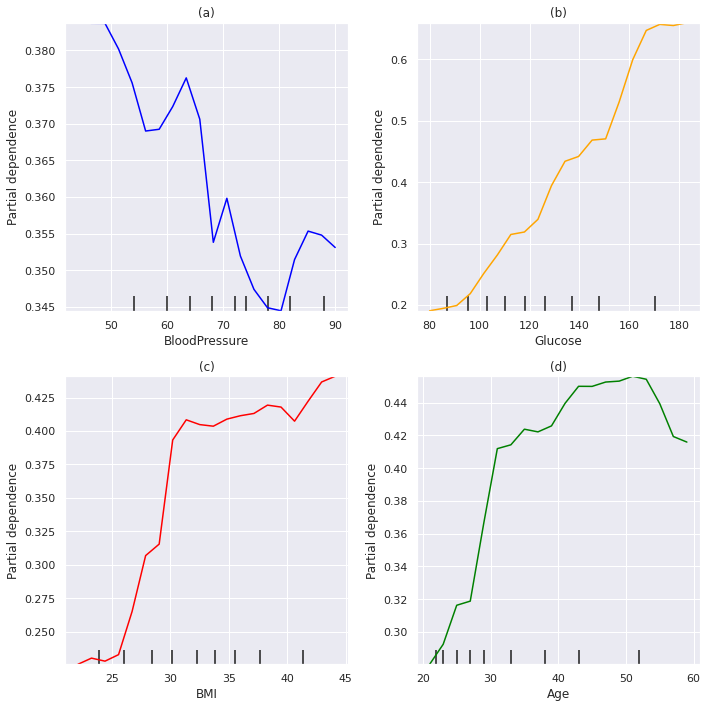

In [8]:
## 1-Dimensional PDP

fig, axs = plt.subplots(2,2,figsize=(10, 10))

feats_1d = ['BloodPressure']
plot_partial_dependence(rf, X_train, feats_1d, grid_resolution=20, 
                        ax=axs[0,0], n_jobs=-1)
axs[0,0].set_title("(a)")
plt.gca().get_lines()[0].set_color("blue")

feats_1d = ['Glucose']
plot_partial_dependence(rf, X_train, feats_1d, grid_resolution=20, 
                        ax=axs[0,1], n_jobs=-1,)
axs[0,1].set_title("(b)")
plt.gca().get_lines()[0].set_color("orange")

feats_1d = ['BMI']
plot_partial_dependence(rf, X_train, feats_1d, grid_resolution=20, 
                        ax=axs[1,0], n_jobs=-1)
axs[1,0].set_title("(c)")
plt.gca().get_lines()[0].set_color("red")

feats_1d = ['Age']
plot_partial_dependence(rf, X_train, feats_1d, grid_resolution=20, 
                        ax=axs[1,1], n_jobs=-1)
axs[1,1].set_title("(d)")
plt.gca().get_lines()[0].set_color("green")

xlim = axs[0,0].get_xlim()
ylim = axs[0,0].get_ylim()

plt.tight_layout()

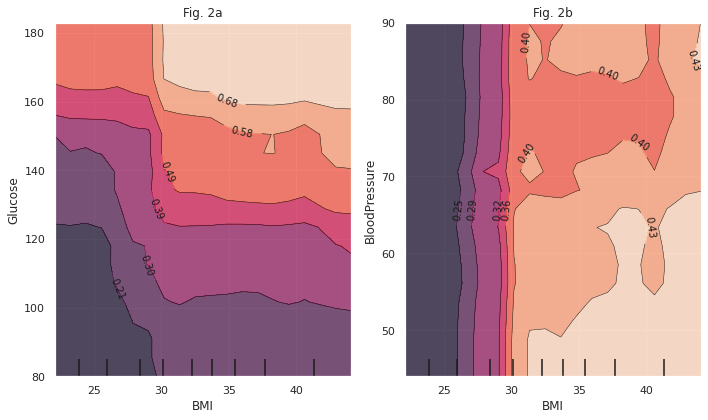

In [9]:
# 2-Dimensional PDP contour plots

fig, axs = plt.subplots(1,2,figsize=(10, 6))

feats_1d = [('BMI','Glucose')]
plot_partial_dependence(rf, X_train, feats_1d, grid_resolution=20, ax=axs[0], n_jobs=-1)
axs[0].set_title("Fig. 2a")
plt.tight_layout()

feats_1d = [('BMI','BloodPressure')]
plot_partial_dependence(rf, X_train, feats_1d, grid_resolution=20, ax=axs[1], n_jobs=-1)
axs[1].set_title("Fig. 2b")
plt.tight_layout()


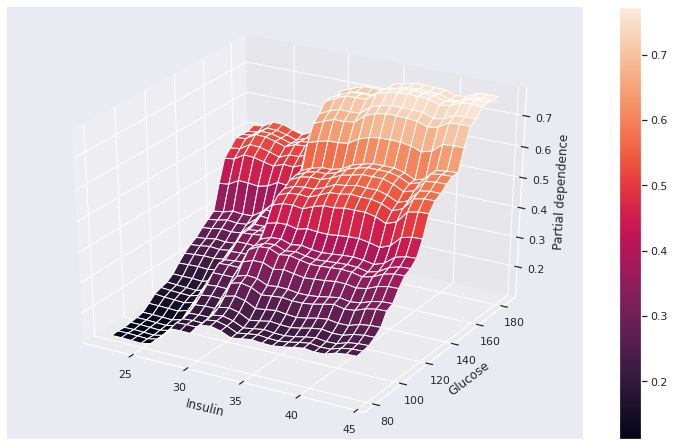

<Figure size 432x288 with 0 Axes>

In [10]:
## 2-Dimensional PDP Surface plots
from mpl_toolkits.mplot3d import Axes3D

fig_2d = plt.figure(figsize=(10, 6))
ax = Axes3D(fig_2d)

# Prepare PDP Data
feats_2d = ('BMI', 'Glucose')
pdp_2d = partial_dependence(rf, X_train, features=feats_2d, 
                            grid_resolution=25, kind="average")
pdp_X, pdp_Y = np.meshgrid(pdp_2d['values'][0], pdp_2d['values'][1])
pdp_Z = pdp_2d.average[0].T

# Generate Plot
surf = ax.plot_surface(pdp_X, pdp_Y, pdp_Z, rstride=1, 
                       cstride=1,cmap=plt.get_cmap()) 
ax.set_xlabel('Insulin')
ax.set_ylabel('Glucose')
ax.set_zlabel('Partial dependence')
plt.colorbar(surf)
plt.show()
plt.tight_layout()

# ICE Plots

The Individual Conditional Expectation (ICE) plot is analogous to the PD plot in that it visualizes the relationship of the output on a feature but plots a separate line for each instance. Whereas partial dependence plots average out and obscure possible heterogeneous effects in the data samples, ICE plots can clearly show when distinct sub-groups behave differently.

In [11]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
import seaborn as sns
sns.set()

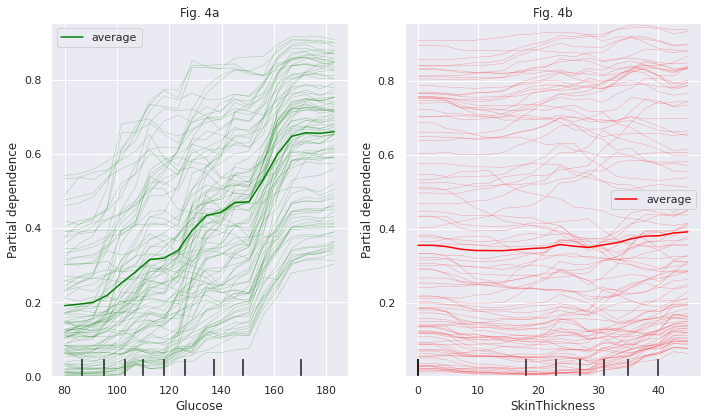

In [12]:
# 1-Dimensional ICE Plots

fig, axs = plt.subplots(1,2,figsize=(10, 6))

feats_1d = ['Glucose']
plot_partial_dependence(rf, X_train, feats_1d, grid_resolution=20, 
                        ax=axs[0], n_jobs=-1, kind='both', 
                        line_kw={'color':'green'}, subsample=100)
axs[0].set_title("Fig. 4a")
plt.tight_layout()

feats_1d = ['SkinThickness']
plot_partial_dependence(rf, X_train, feats_1d, grid_resolution=20, 
                        ax=axs[1], n_jobs=-1, kind='both',
                        line_kw={'color':'red'}, subsample=100)
axs[1].set_title("Fig. 4b")
plt.tight_layout()


Text(0.5, 0, 'BloodPressure')

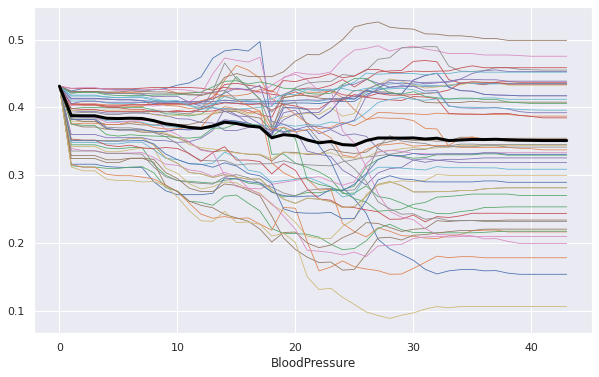

In [13]:
# 1-Dimensional Centered ICE Plots

feat = 'BloodPressure'
ice = partial_dependence(rf, X_train, [feat],kind='both')

lines = ice.individual[0]
origin = ice['average'][0][0]
for i in range(len(lines)):
  offset = lines[i][0]
  for j in range(len(lines[i])):
    lines[i][j] += -offset + origin

fig, axs = plt.subplots(1,figsize=(10, 6))

idx = np.random.randint(614, size=50)
plt.plot(lines[idx,:].T,linewidth=.8)
plt.plot(ice['average'][0],color='black',linewidth=3)
plt.xlabel(feat)

# Ceteris Paribus

The Ceteris Paribus (CP) plot is named after the Latin phrase “ceteris paribus” meaning “all other things being equal.” Like the PD and ICE plots, it is useful for explaining the influence of the features of a model on its output. Specifically, the CP plot shows the relationship between the change in model prediction and changes in feature values for a single data instance.

In [14]:
import dalex as dx

SAMPLE_TO_EXPLAIN = 20

instance = X_train.iloc[SAMPLE_TO_EXPLAIN]
label = y_train.iloc[SAMPLE_TO_EXPLAIN]

exp = dx.Explainer(rf, X_train, y_train)

cp = exp.predict_profile(instance,label="CP")
cp.plot()

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Preparation of a new explainer is initiated

  -> data              : 614 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 614 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f1cd9e6c320> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.001, mean = 0.36, max = 0.951
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.531, mean = 8.41e-05, max = 0.609
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 8/8 [00:00<00:00, 14.43it/s]


# ALE Plots

Accumulated local effects (ALE) plots are similar to PD plots in that they visual- ize the average relationship between features and the output of a machine learning model. However, PD plots are biased when correlations between features are significant. ALE plots are an alternative that can account for potential correlations and feature interactions. 

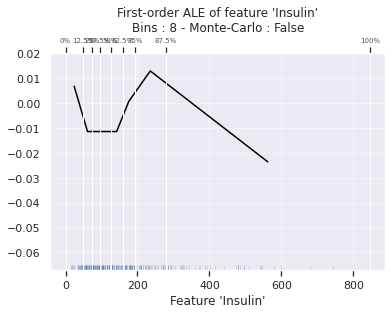

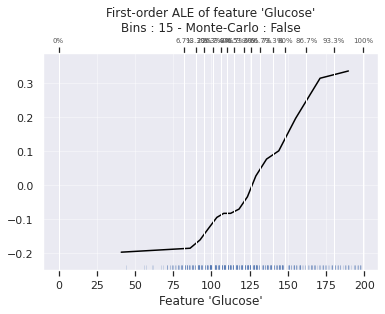

In [15]:
# First Order ALE Plot

from alepython import ale_plot

ale_plot(rf, X_train, ["Insulin"], bins=15, monte_carlo=False)
plt.close()

ale_plot(rf, X_train, ["Glucose"], bins=15, monte_carlo=False)
plt.close()

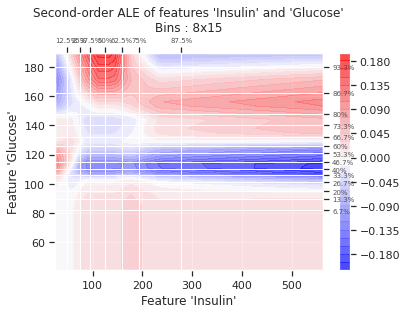

<Figure size 432x288 with 0 Axes>

In [16]:
# Second-Order ALE Plot

from alepython import ale_plot

ale_plot(rf, X_train, ["Insulin","Glucose"], bins=15, monte_carlo=False)
plt.rc('axes', labelsize=10)
plt.tight_layout()



# Breakdown Plots

Breakdown plots visualize the influence of model features on the model predic- tion by decomposing the prediction into individual attributions of each feature for a specific data instance. It is a local method that explains which features have the strongest influence on a particular prediction.

In [17]:
import dalex as dx

SAMPLE_TO_EXPLAIN = 20

exp = dx.Explainer(rf, X_train, y_train)
instance = X_train.iloc[SAMPLE_TO_EXPLAIN]
label = y_train.iloc[SAMPLE_TO_EXPLAIN]

bd = exp.predict_parts(instance, type='break_down', label="Breakdown")

bd.plot()
bd.result

Preparation of a new explainer is initiated

  -> data              : 614 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 614 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f1cd9e6c320> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.001, mean = 0.36, max = 0.951
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.531, mean = 8.41e-05, max = 0.609
  -> model_info        : package sklearn

A new explainer has been created!


variable_name variable_value  ... position      label
0                 intercept              1  ...        9  Breakdown
1                   Glucose          145.0  ...        8  Breakdown
2               Pregnancies            9.0  ...        7  Breakdown
3                       Age           40.0  ...        6  Breakdown
4                       BMI           37.9  ...        5  Breakdown
5             SkinThickness           46.0  ...        4  Breakdown
6  DiabetesPedigreeFunction          0.637  ...        3  Breakdown
7                   Insulin          130.0  ...        2  Breakdown
8             BloodPressure           80.0  ...        1  Breakdown
9                                           ...        0  Breakdown

[10 rows x 8 columns]

# iBreakdown Plots

Interaction Breakdown plots (iBreakdown) capture feature interactions while generating explanations for feature contributions. To do so, iBreakdown bootstraps data samples to a baseline model with fixed parameters and uses Breakdown plots to generate a set of break down explanations.

In [18]:
import dalex as dx

SAMPLE_TO_EXPLAIN = 20

exp = dx.Explainer(rf, X_train, y_train)
instance = X_train.iloc[SAMPLE_TO_EXPLAIN]
label = y_train.iloc[SAMPLE_TO_EXPLAIN]

ibd = exp.predict_parts(instance, type='break_down_interactions', label="iBreakdown")

ibd.plot()
ibd.result

Preparation of a new explainer is initiated

  -> data              : 614 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 614 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f1cd9e6c320> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.001, mean = 0.36, max = 0.951
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.531, mean = 8.41e-05, max = 0.609
  -> model_info        : package sklearn

A new explainer has been created!


variable_name variable_value  ... position       label
0                 intercept              1  ...        9  iBreakdown
1                   Glucose          145.0  ...        8  iBreakdown
2               Pregnancies            9.0  ...        7  iBreakdown
3                       Age           40.0  ...        6  iBreakdown
4                       BMI           37.9  ...        5  iBreakdown
5             SkinThickness           46.0  ...        4  iBreakdown
6  DiabetesPedigreeFunction          0.637  ...        3  iBreakdown
7             BloodPressure           80.0  ...        2  iBreakdown
8                   Insulin          130.0  ...        1  iBreakdown
9                                           ...        0  iBreakdown

[10 rows x 8 columns]

# H-Statistic

H-statistic plots can allow us to measure the interaction effect between a feature and model output or between two fea- tures. It can be interpreted as the contribution to variance by the interaction effect. It is computationally expensive and cannot explain the nature of the interaction.




In [19]:
# Reference: Seppe "Macuyiko" vanden Broucke

import itertools
import seaborn as sns

def center(arr): 
  return arr - np.mean(arr)

def compute_f_vals_manual(model, X, feats=None):

    def _partial_dependence(model, X, feats):
        P = X.copy()
        for f in P.columns:
            if f in feats: continue
            P.loc[:,f] = np.mean(P[f])
        return model.predict_proba(P)[:,1]

    f_vals = {}
    if feats is None:
        feats = list(X.columns)

    full_preds = _partial_dependence(model, X, feats)
    f_vals[tuple(feats)] = center(full_preds)

    for n in range(1, len(feats)):
        for subset in itertools.combinations(feats, n):
            pd_part = _partial_dependence(model, X, subset)
            f_vals[tuple(subset)] = center(pd_part)

    return f_vals


def compute_h_val(f_vals, selectedfeatures):
    numer_els = f_vals[tuple(selectedfeatures)].copy()
    denom_els = f_vals[tuple(selectedfeatures)].copy()
    for n in range(len(selectedfeatures)-1, 0, -1):
        for subfeatures in itertools.combinations(selectedfeatures, n):
            sign = -1 if n == len(selectedfeatures) - 1 else +1
            numer_els += sign * f_vals[tuple(subfeatures)]
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return np.sqrt(numer/denom)


def compute_h_val_any(f_vals, allfeatures, selectedfeature):
    otherfeatures = list(allfeatures)
    otherfeatures.remove(selectedfeature)
    denom_els = f_vals[tuple(allfeatures)].copy()
    numer_els = denom_els.copy()
    numer_els -= f_vals[(selectedfeature,)]
    numer_els -= f_vals[tuple(otherfeatures)]
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return np.sqrt(numer/denom)


<BarContainer object of 8 artists>

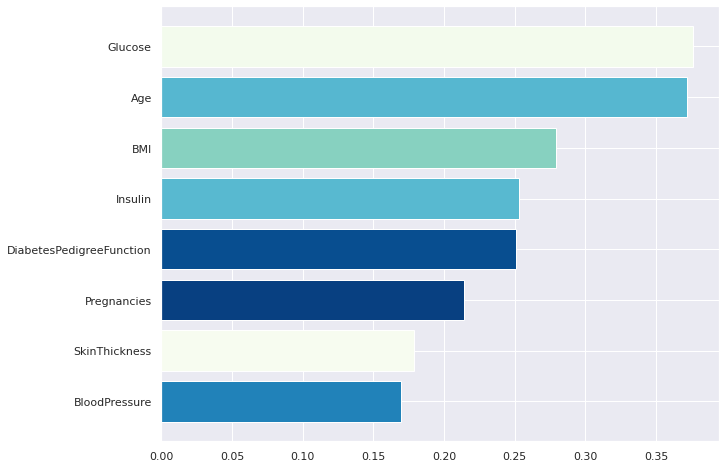

In [20]:
sns.set()
fig, ax = plt.subplots(1,figsize=(10,8))

subsets = []
h_vals = []

feats = list(X.columns)
f_vals = compute_f_vals_manual(rf, X, feats=feats)

for subset in feats:
    h_val = compute_h_val_any(f_vals, feats, subset)
    subsets.append(subset)
    h_vals.append(h_val)

my_cmap = plt.get_cmap("GnBu_r")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

sorted_idx = np.array(h_vals).argsort()
plt.barh(range(len(h_vals)), 
         np.array(h_vals)[sorted_idx], 
         tick_label=np.array(subsets)[sorted_idx],
         color=my_cmap(rescale(np.array(h_vals))))


# Two-way H-Statistic

<BarContainer object of 28 artists>

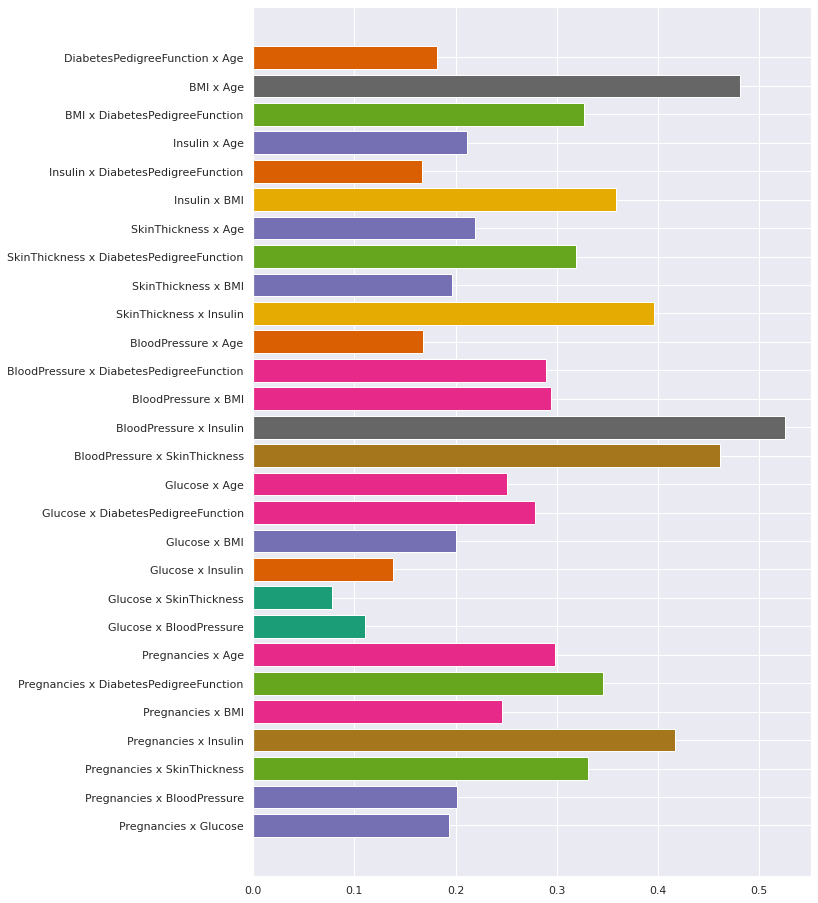

In [21]:
# Reference: Seppe "Macuyiko" vanden Broucke

sns.set()
fig, ax = plt.subplots(1,figsize=(10,16))

subsets = []
h_vals = []

feats = list(X.columns)

for n in [2]:
    for subset in itertools.combinations(feats, n):
        h_val = compute_h_val(f_vals, subset)
        subsets.append(' x '.join(subset))
        h_vals.append(h_val)

my_cmap = plt.get_cmap("Dark2")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.barh(range(len(h_vals)), 
         np.array(h_vals), 
         tick_label=np.array(subsets),
         color=my_cmap(rescale(np.array(h_vals))))


# Permutation Feature Importance

Permutation feature importance is based on the notion that the importance of a feature is related to the rise in model prediction error when the values of the feature are shuffled. The greater the error, the stronger the relationship between the feature and model prediction.

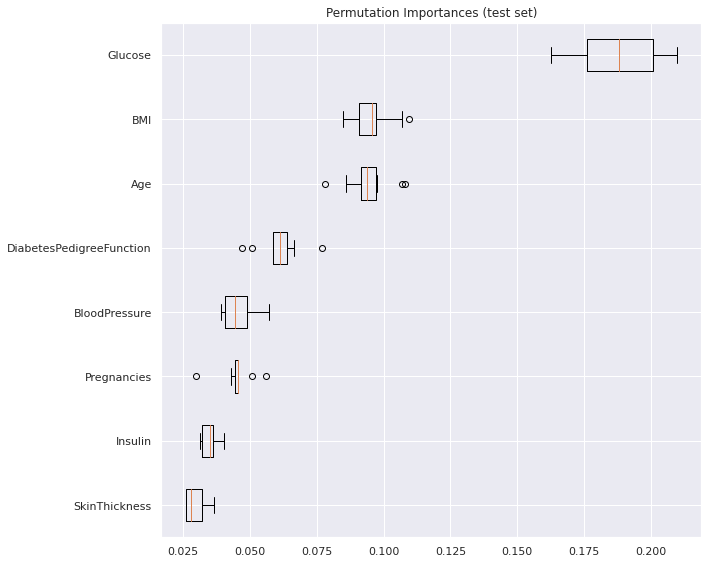

In [22]:
from sklearn.inspection import permutation_importance

imp = permutation_importance(rf, X, y, n_repeats=10)

sorted_idx = imp.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(imp.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Leave-One-Covariate-Out (LOCO)

Leave-One-Covariate-Out (LOCO), also known as Leave-One- Feature-Out (LOFO), sequentially drops each feature, retrains the model, and compares the subsequent model error with respect to the baseline model that includes all features. 

/usr/local/lib/python3.7/dist-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



  0%|          | 0/8 [00:00<?, ?it/s]

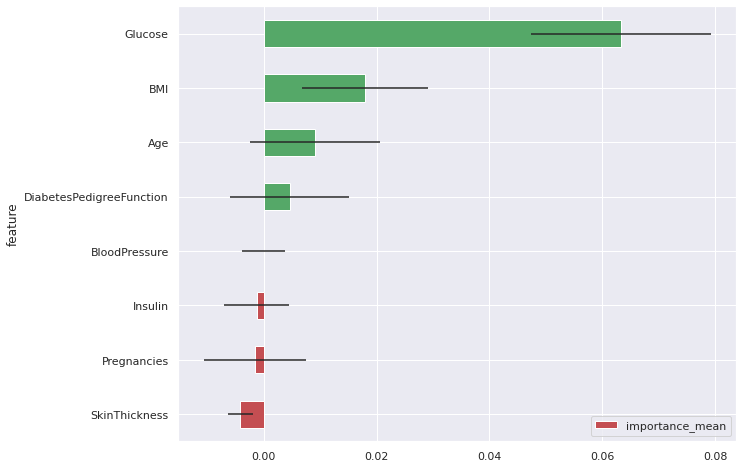

In [23]:
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline

sample_df = pc

cv = KFold(n_splits=4, shuffle=False)
dataset = Dataset(df=sample_df, target="Outcome", features=X.columns)

lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc",model=rf)
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(10,8))

# SHAP

SHAP (Shapley Additive Explanations) provides an unique, additive feature importance explanation for individual data instances. SHAP computes Shapley values of a conditional expectation function of the model over a dataset.

In [24]:
import xgboost
import shap

explainer = shap.Explainer(rf)
explanation = explainer(X)

In [25]:
shap.initjs()
SAMPLE_TO_EXPLAIN = 20
shap.plots.force(explainer.expected_value[1],
                 explanation.values[SAMPLE_TO_EXPLAIN,:,1],
                 X.iloc[SAMPLE_TO_EXPLAIN,:], 
                 plot_cmap="PkYg")

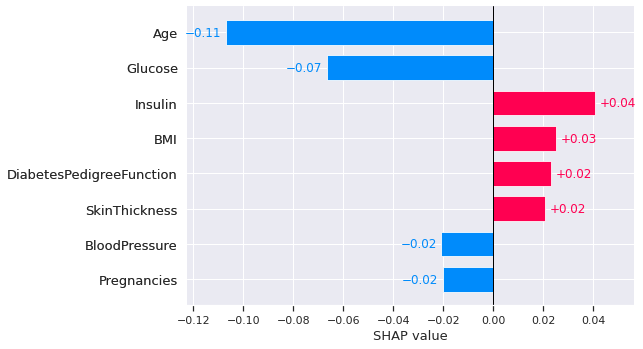

In [26]:
shap.plots.bar(explanation[SAMPLE_TO_EXPLAIN,:,1],)

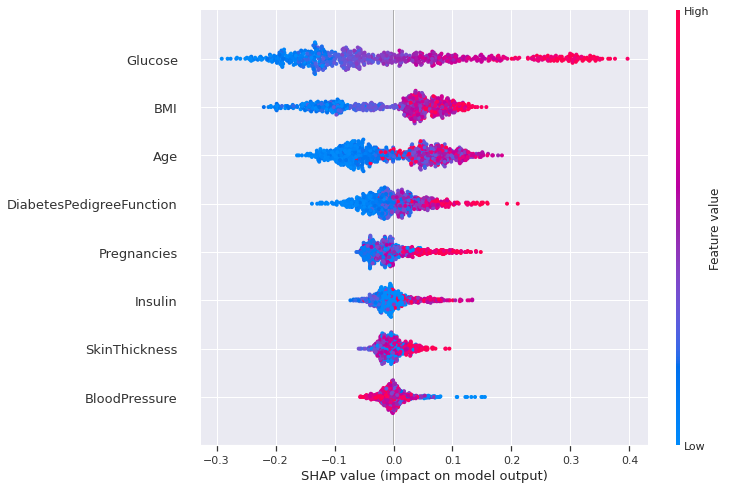

In [27]:
shap.plots.beeswarm(explanation[:,:,1], plot_size=(10,8))

## Anchors

Anchors is a high-precision method for generating local ex- planations by extracting a set of if-then rules. These rules have the property in that they serve as “anchors” for a set of features such that changes in other features will not change the model output.

In [28]:
from alibi.explainers import AnchorTabular
from alibi.utils.data import gen_category_map

predict_fn = lambda x: rf.predict_proba(x)
feature_names = list(X_train.columns)
class_names = list([0,1])
category_map = gen_category_map(X_train, categorical_columns=None)
explainer = AnchorTabular(predict_fn, feature_names, categorical_names=category_map)
explainer.fit(X_train.to_numpy())

anchor = []
prediction = []
precision = []
coverage = []

for idx in range(5):
  pred = class_names[explainer.predictor(X_train.iloc[idx].to_numpy().reshape(1, -1))[0]]
  explanation = explainer.explain(X_train.iloc[idx].to_numpy(), threshold=0.95)
  anchor.append(' AND '.join(explanation.anchor))
  coverage.append(explanation.coverage)
  precision.append(explanation.precision)
  prediction.append(pred)

exp = pd.DataFrame()
exp['anchor'] = anchor
exp['precision'] = precision
exp['coverage'] = coverage
exp['prediction'] = prediction
pd.set_option('display.max_colwidth', 140)
exp

anchor  ...  prediction
0                                           Glucose <= 100.00 AND BMI <= 27.40  ...           0
1                                 Glucose <= 100.00 AND BloodPressure <= 62.00  ...           0
2                                           Glucose <= 100.00 AND Age <= 24.00  ...           0
3  Glucose > 143.00 AND BMI > 36.60 AND Pregnancies > 3.00 AND Insulin <= 0.00  ...           1
4                                           Glucose <= 100.00 AND Age <= 24.00  ...           0

[5 rows x 4 columns]

# Global Surrogate

Global surrogate methods attempt to approximate the predictions of a black-box model by using a simpler, more interpretable model in order to explain model behavior. 

R-squared =  0.3596673596673595


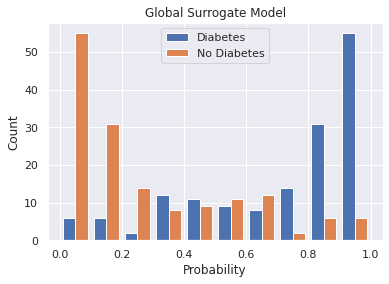

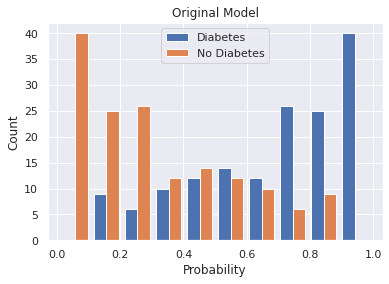

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

## Model to Explain = Random Forest
rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=2, random_state=42)
rf.fit(X_train, y_train.Outcome)
y_rf = rf.predict(X_test)
y_rf_prob = rf.predict_proba(X_test)

## Global Surrogate = Logistic Regression
clf = LogisticRegression(max_iter=5000,penalty='l1',solver='liblinear',C=10000)
clf.fit(X_train,rf.predict(X_train))
y_bb = clf.predict(X_test)
y_bb_prob = clf.predict_proba(X_test)

fig, ax = plt.subplots()
ax.hist(y_bb_prob)
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.legend(["Diabetes","No Diabetes"])
ax.set_title("Global Surrogate Model")

fig, ax = plt.subplots()
ax.hist(y_rf_prob)
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.legend(["Diabetes","No Diabetes"])
ax.set_title("Original Model")

print("R-squared = ",r2_score(y_bb, y_rf))

# LIME

Local Interpretable Model-Agnostic Explanations (LIME) is a model-agnostic approach that generates interpretable explanations of the individual prediction of any model in the region around the prediction.

In [30]:
from lime.lime_tabular import LimeTabularExplainer

class_names = list(y.Outcome.unique())
explainer = LimeTabularExplainer(X_train.to_numpy(), 
                                 training_labels=y_train.to_numpy(),
                                 feature_names=X_train.columns, 
                                 class_names=["No Diabetes","Diabetes"], 
                                 discretize_continuous=False)

In [31]:
SAMPLE_TO_EXPLAIN = 11
exp = explainer.explain_instance(X_test.iloc[SAMPLE_TO_EXPLAIN].to_numpy(), rf.predict_proba, num_features=8, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False,)

## Contrastive Explanations Method

The contrastive explanation method (CEM), also known as differential explanations, does not explain a specific prediction but instead aims to explain why a prediction was made in contrast to another. It generates local explanations for the prediction of black-box classifier models on individual instances. CEM is based on the notion of pertinent positives (PP) and pertinent negatives (PN).

In [32]:
from alibi.explainers import CEM
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

#tf.compat.v1.disable_eager_execution()
tf.keras.backend.clear_session()

def exp_model():
    x_in = Input(shape=(8,))
    x_out = Dense(2, activation='softmax')(x_in)
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

X = pc.drop(['Outcome'],axis=1)
y = pc[['Outcome']]

#scaling on/off
pc[conts] = scaler.fit_transform(X[conts])
#pc[conts] = X[conts]

# Define features and target
X = pc.drop(['Outcome'],axis=1)
y = pc[['Outcome']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

predict_fn = exp_model()
predict_fn.fit(X_train.to_numpy(), to_categorical(y_train), batch_size=16, epochs=500, verbose=0)

# rf = RandomForestClassifier(n_estimators=500, 
#                             min_samples_leaf=2, 
#                             random_state=42)
# rf.fit(X_train, y_train.Outcome)
#predict_fn = lambda x: rf.predict_proba(x)

feature_names = X_train.columns
class_names = ["No Diabetes","Diabetes"]

SAMPLE_TO_EXPLAIN = 11
X = X_test.iloc[SAMPLE_TO_EXPLAIN].to_numpy().reshape((1,) + X_test.iloc[SAMPLE_TO_EXPLAIN].shape)
print('Prediction on instance to be explained: {}'.format(class_names[np.argmax(rf.predict(X))]))
print('Prediction probabilities for each class on the instance: {}'.format(rf.predict_proba(X)))

Prediction on instance to be explained: No Diabetes
Prediction probabilities for each class on the instance: [[0.88107965 0.11892035]]


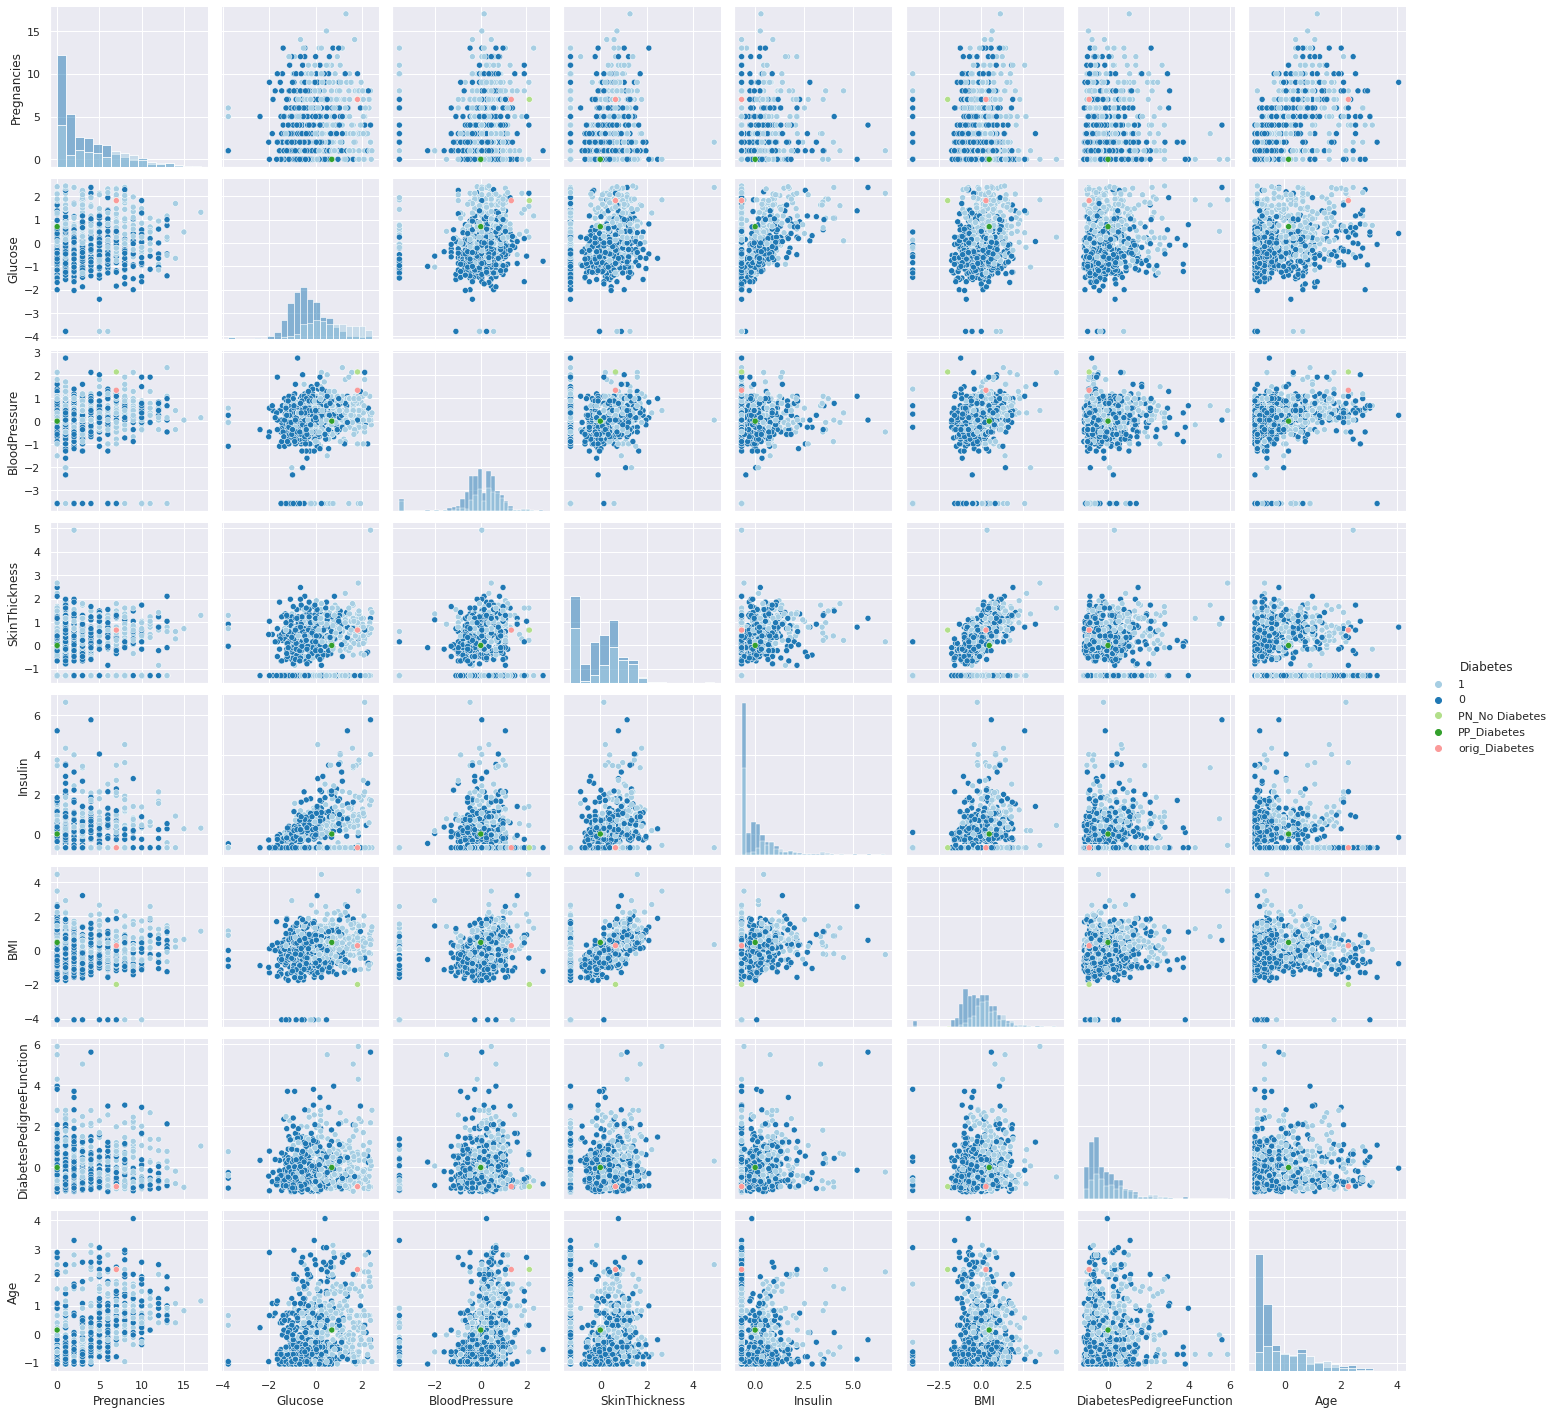

In [33]:
mode = 'PN'  
shape = (1,) + X_train.to_numpy().shape[1:]

eps0 = np.array([[1e-2, 1e-2]])  
eps1 = np.array([[1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]]) 
eps = (eps0, eps1)

cem = CEM(predict_fn, mode, shape, kappa=0, beta=.1, 
          feature_range=(X_train.min(), X_train.max()),
          eps=eps, update_num_grad=100)
cem.fit(X_train.to_numpy(), no_info_type='median')  
explanation = cem.explain(X, verbose=False)
expl = {}
expl['PN'] = explanation.PN
expl['PN_pred'] = explanation.PN_pred

mode = 'PP'

cem = CEM(predict_fn, mode, shape, kappa=0, beta=.1, 
          feature_range=(X_train.min(), X_train.max()),
          eps=eps, update_num_grad=100)
cem.fit(X_train.to_numpy(), no_info_type='median')  
explanation = cem.explain(X, verbose=False)
expl['PP'] = explanation.PP
expl['PP_pred'] = explanation.PP_pred

## Visualize

dataset = pc.drop(['Outcome'],axis=1).to_numpy()

df = pd.DataFrame(dataset, columns=feature_names)
df['Diabetes'] = y.Outcome.to_numpy()
pn = pd.DataFrame(expl['PN'], columns=feature_names)
pn['Diabetes'] = 'PN_' + class_names[expl['PN_pred']]
pp = pd.DataFrame(expl['PP'], columns=feature_names)
pp['Diabetes'] = 'PP_' + class_names[expl['PP_pred']]
orig_inst = pd.DataFrame(explanation.X, columns=feature_names)
orig_inst['Diabetes'] = 'orig_' + class_names[explanation.X_pred]
df = df.append([pn, pp, orig_inst], ignore_index=True)

fig = sns.pairplot(df, hue='Diabetes', diag_kind='hist', palette="Paired");

## k Nearest Neighbors

The k-nearest neighbor (kNN) model can be used as an explanatory model to provide local explanations for black-box classifier predictions by assigning the most common class of the k data samples in closest proximity to the data instance of interest.

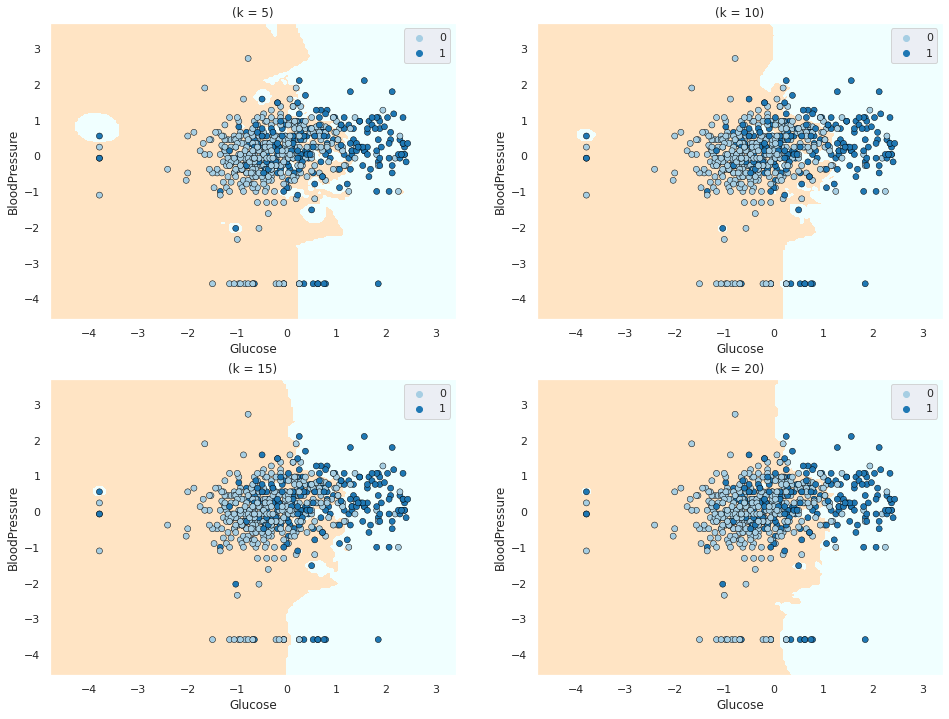

In [34]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 5

# import some data to play with

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = X_train.iloc[:,1:3].to_numpy()
y = y_train.Outcome.to_numpy()
feature_names = X_train.columns[1:3]
target_names = [0,1]

h = .05  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['bisque', 'azure'])
cmap_bold = ['darkorange', 'c', 'darkblue']
weights = 'distance'

n = 0
fig,ax = plt.subplots(2,2,figsize=(16, 12))
#for weights in ['uniform', 'distance']:

for n_neighbors in [5,10,15,20]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    ax.flat[n].contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(ax = ax.flat[n],x=X[:, 0], y=X[:, 1], hue=y,
                    palette="Paired", alpha=1.0, edgecolor="black")
    ax.flat[n].set_xlim(xx.min(), xx.max())
    ax.flat[n].set_ylim(yy.min(), yy.max())
    ax.flat[n].set_title("(k = %i)"
              % (n_neighbors))
    ax.flat[n].set_xlabel(feature_names[0])
    ax.flat[n].set_ylabel(feature_names[1])
    n += 1
plt.show()

## Trust Scores

he Trust Score method (TSM) aims to measure the confidence of a black-box classifier model in making a local prediction. It is based on using a modified nearest neighbor classifier to measure the trust score of an instance of interest.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from alibi.confidence import TrustScore


clf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=5, max_depth=3,random_state=23)
clf.fit(X_train, y_train.Outcome)
y_pred = clf.predict(X_test)

ts = TrustScore(k_filter=20,  # nb of neighbors used for kNN distance or probability to filter out outliers
                alpha=.05,  # target fraction of instances to filter out
                filter_type='distance_knn',  # filter method: None, 'distance_knn' or 'probability_knn'
                leaf_size=10,  # affects speed and memory to build KDTrees, memory scales with n_samples / leaf_size
                metric='euclidean',  # distance metric used for the KDTrees
                dist_filter_type='point')  # 'point' uses distance to k-nearest point
                                           # 'mean' uses average distance from the 1st to the kth nearest point

ts.fit(X_train.to_numpy(), y_train.Outcome.to_numpy(), classes=2)  # classes = nb of prediction classes

score, closest_class = ts.score(X_test.to_numpy(),
                                y_pred, k=2,  # kth nearest neighbor used
                                              # to compute distances for each class
                                dist_type='mean')  # 'point' or 'mean' distance option
print(f'Trust scores: {score[:5]}')
print(f'\nClosest not predicted class: {closest_class[:5]}')   

Trust scores: [1.2402053509624573 1.2009282896881217 1.9462187824375279
 0.5402689142668485 0.7436148112399988]

Closest not predicted class: [1 1 1 1 1]


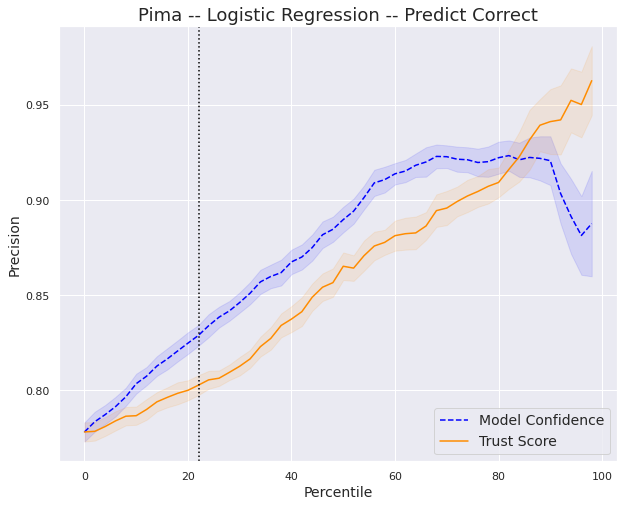

In [36]:
def run_lr(X_train, y_train, X_test):
    clf = LogisticRegression(max_iter=1000,solver='liblinear',C=1000,multi_class='auto')
#    clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    probas = y_pred_proba[range(len(y_pred)), y_pred]  # probabilities of predicted class
    return y_pred, probas

def plot_precision_curve(plot_title,
                         percentiles,
                         labels,
                         final_tp,
                         final_stderr,
                         final_misclassification,
                         colors = ['blue', 'darkorange', 'brown', 'red', 'purple']):

    plt.title(plot_title, fontsize=18)
    colors = colors + list(cm.rainbow(np.linspace(0, 1, len(final_tp))))
    plt.xlabel("Percentile", fontsize=14)
    plt.ylabel("Precision", fontsize=14)

    for i, label in enumerate(labels):
        ls = "--" if ("Model" in label) else "-"
        plt.plot(percentiles, final_tp[i], ls, c=colors[i], label=label)
        plt.fill_between(percentiles,
                         final_tp[i] - final_stderr[i],
                         final_tp[i] + final_stderr[i],
                         color=colors[i],
                         alpha=.1)

    if 0. in percentiles:
        plt.legend(loc="lower right", fontsize=14)
    else:
        plt.legend(loc="upper left", fontsize=14)
    model_acc = 100 * (1 - final_misclassification)
    plt.axvline(x=model_acc, linestyle="dotted", color="black")
    plt.show()

def run_precision_plt(X, y, nfolds, percentiles, run_model, test_size=.5,
                      plt_title="", plt_names=[], predict_correct=True, classes=2):

    def stderr(L):
        return np.std(L) / np.sqrt(len(L))

    all_tp = [[[] for p in percentiles] for _ in plt_names]
    misclassifications = []
    mult = 1 if predict_correct else -1

    folds = StratifiedShuffleSplit(n_splits=nfolds, test_size=test_size, random_state=0)
    for train_idx, test_idx in folds.split(X, y):
        # create train and test folds, train model and make predictions
        X_train, y_train = X[train_idx, :], y[train_idx]
        X_test, y_test = X[test_idx, :], y[test_idx]
        y_pred, probas = run_model(X_train, y_train, X_test)
        # target points are the correctly classified points
        target_points = np.where(y_pred == y_test)[0] if predict_correct else np.where(y_pred != y_test)[0]
        final_curves = [probas]
        # calculate trust scores
        ts = TrustScore(k_filter=20,  # nb of neighbors used for kNN distance or probability to filter out outliers
                alpha=.05,  # target fraction of instances to filter out
                filter_type='distance_knn',  # filter method: None, 'distance_knn' or 'probability_knn'
                leaf_size=10,  # affects speed and memory to build KDTrees, memory scales with n_samples / leaf_size
                metric='euclidean',  # distance metric used for the KDTrees
                dist_filter_type='point')  # 'point' uses distance to k-nearest point
        ts.fit(X_train, y_train, classes=classes)
        scores, _ = ts.score(X_test, y_pred)
        final_curves.append(scores)  # contains prediction probabilities and trust scores
        # check where prediction probabilities and trust scores are above a certain percentage level
        for p, perc in enumerate(percentiles):
            high_proba = [np.where(mult * curve >= np.percentile(mult * curve, perc))[0] for curve in final_curves]
            if 0 in map(len, high_proba):
                continue
            # calculate fraction of values above percentage level that are correctly (or incorrectly) classified
            tp = [len(np.intersect1d(hp, target_points)) / (1. * len(hp)) for hp in high_proba]
            for i in range(len(plt_names)):
                all_tp[i][p].append(tp[i])  # for each percentile, store fraction of values above cutoff value
        misclassifications.append(len(target_points) / (1. * len(X_test)))

    # average over folds for each percentile
    final_tp = [[] for _ in plt_names]
    final_stderr = [[] for _ in plt_names]
    for p, perc in enumerate(percentiles):
        for i in range(len(plt_names)):
            final_tp[i].append(np.mean(all_tp[i][p]))
            final_stderr[i].append(stderr(all_tp[i][p]))

    for i in range(len(all_tp)):
        final_tp[i] = np.array(final_tp[i])
        final_stderr[i] = np.array(final_stderr[i])

    final_misclassification = np.mean(misclassifications)

    # create plot
    plot_precision_curve(plt_title, percentiles, plt_names, final_tp, final_stderr, final_misclassification)

plt.figure(figsize=(10, 8))
X = pc.drop(['Outcome'],axis=1).to_numpy()
y = pc['Outcome'].to_numpy()
percentiles = [0 + 2*i for i in range(50)]
nfolds = 10
plt_names = ['Model Confidence', 'Trust Score']
plt_title = 'Pima -- Logistic Regression -- Predict Correct'
run_precision_plt(X, y, nfolds, percentiles, run_lr, plt_title=plt_title,
                  plt_names=plt_names, predict_correct=True)

## Counterfactuals

The Counterfactual Explanations (CE) method generates local explanations by detailing the changes to an input instance that would cause the prediction of a model to change. Due to their counterfactual nature, CF explanations are intuitive and highly human-interpretable.

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Original prediction: 0
Counterfactual prediction: 1

Glucose: -4.000391960144043
BloodPressure: 1.6572900092363372


Text(0, 0.5, 'BloodPressure')

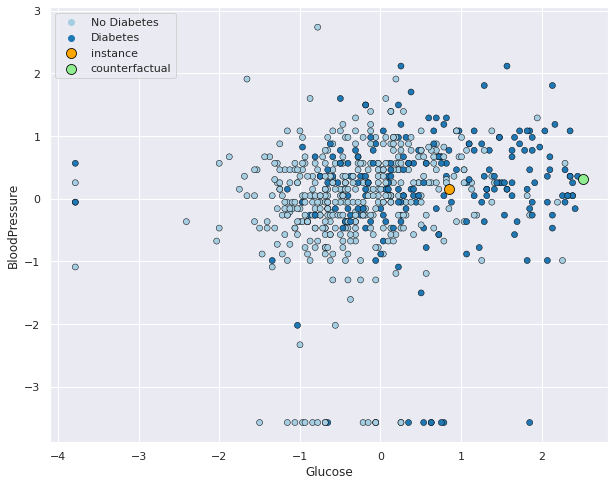

In [37]:
import tensorflow as tf
#tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

from alibi.explainers import Counterfactual

def exp_model():
    x_in = Input(shape=(8,))
    x = Dense(40, activation='relu')(x_in)
    x = Dense(40, activation='relu')(x)
    x_out = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return nn

predict_fn = exp_model()
predict_fn.fit(X_train.to_numpy(), to_categorical(y_train.Outcome), batch_size=64, epochs=500, verbose=0)

cf = Counterfactual(predict_fn, shape, distance_fn='l1', target_proba=1.0,
                    target_class='other', max_iter=1000, early_stop=50, lam_init=1e-1,
                    max_lam_steps=10, tol=0.05, learning_rate_init=0.1,
                    feature_range=(-1e10, 1e10), eps=0.01, init='identity',
                    decay=True, write_dir=None, debug=False)

x_test = X_test.to_numpy()[1].reshape((1,) + X_test.to_numpy()[1].shape)
explanation = cf.explain(x_test)

print(f'Original prediction: {explanation.orig_class}')
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print()

orig = X
counterfactual = explanation.cf['X']
delta = counterfactual - orig
for i, f in enumerate(feature_names):
    if np.abs(delta[0][i]) > 1e-4:
        print('{}: {}'.format(f, delta[0][i]))

fig,ax = plt.subplots(figsize=(10,8))
labelnames = ["Diabetes" if i else "No Diabetes" for i in y_train.Outcome.tolist()]
sns.scatterplot(ax=ax,x=X_train.to_numpy()[:, 1], y=X_train.to_numpy()[:, 2], hue=labelnames,
                    palette="Paired", alpha=1.0, edgecolor="black")

instance = X.flatten()
counter = counterfactual.flatten()

x_axis_feature = 1
y_axis_feature = 2
x_label = pc.columns[x_axis_feature]
y_label = pc.columns[y_axis_feature]

sns.scatterplot(ax=ax, x=[instance[x_axis_feature]], y=[instance[y_axis_feature]], color='orange', label='instance',s=100,edgecolor="black")
sns.scatterplot(ax=ax, x=[counter[x_axis_feature]], y=[counter[y_axis_feature]], color='lightgreen', label='counterfactual',s=100,edgecolor="black")
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

## Influential Instances

Influential instances are the set of training data instances that influence the model such that their presence or absence can significantly change the model.

In [38]:
inf = pd.DataFrame(columns=["point","Modified Cook Distance"])
dataset = X_train.copy()
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

base_rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, random_state=42)
base_rf.fit(X_train, y_train.Outcome)
base_y_pred = base_rf.predict(X_test)

for i in range(dataset.shape[0]):
  rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, random_state=42)
  rf.fit(X_train.drop([i]), y_train.drop([i]).Outcome)
  y_pred = rf.predict(X_test)
  inf.loc[i] = [i,sum((base_y_pred - y_pred)**2)]


Text(0, 0.5, 'BloodPressure')

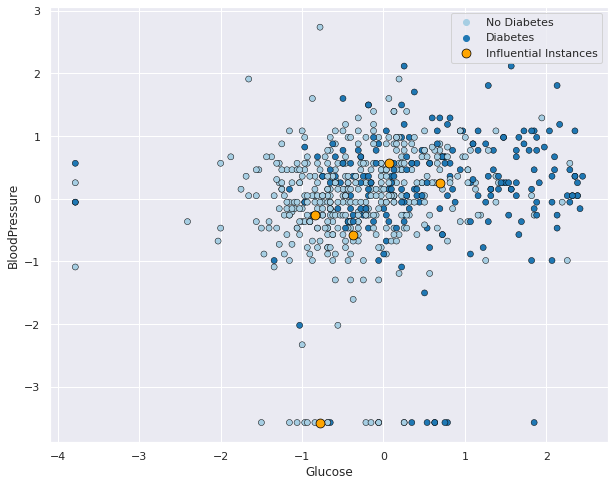

In [39]:
inf_max = inf['Modified Cook Distance'].max()
inf_p = inf[inf['Modified Cook Distance']==inf_max].index
inf_points = X_train.iloc[inf_p.to_list()]

fig,ax = plt.subplots(figsize=(10,8))
labelnames = ["Diabetes" if i else "No Diabetes" for i in y_train.Outcome.tolist()]
sns.scatterplot(ax=ax,x=X_train.iloc[:, 1], y=X_train.iloc[:, 2], hue=labelnames,
                    palette="Paired", alpha=1.0, edgecolor="black")
sns.scatterplot(ax=ax, x=inf_points.iloc[:,1], y=inf_points.iloc[:,2], color='orange', label='Influential Instances',s=80,edgecolor="black")
ax.set_xlabel("Glucose")
ax.set_ylabel("BloodPressure")

